In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os, sys

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.fftpack
import seaborn as sns


# USER INPUTS

In [2]:
"""Experiment name to prepend output files"""
EXPERIMENT = "mouse_sample"

"""Directory path to input data 
    (filtered; output from '1-read_fastq_id_features)
"""
FILTERED_FILEPATH = "../output/filtered-mouse_sample.csv"

"""Directory path to save output"""
OUTPUT_DIRECTORY = "../output"

"""Minimum number of reads as a baseline. Used to simplify data processing."""
MIN_READS = 100


SAMPLE_INFO_FILEPATH = "../helpers/mouse_samples.csv"

# PRESETS AND SCRIPT

In [3]:
"""Column names correspoinding to eponymous variables"""

SAMPLE = 'idx'
QTAG = 'qtag'
BARCODE = 'barcode'
READS = 'readsPF'
MCOUNTS = 'mcountsPF'
PERCENT_MCOUNTS = 'percent_%s'%MCOUNTS
GROUPBY = ['idx']


In [4]:
def load_data(filtered_file, sample=SAMPLE, qtag=QTAG, 
              barcode=BARCODE, mcounts=MCOUNTS, reads=READS):
    """Loads filtered lib-ID-barcode data csv to dict of samples"""
    columns = [sample, qtag, barcode, mcounts, reads]
    # loads excel file (all tabs)
    csv = pd.read_csv(filtered_file, sep=',')
    # filter out null barcodes just in case (if custom user input)
    csv = csv.loc[(csv[qtag]!='None') & (csv[barcode]!='None')]
    csv = csv[columns]
    csv[sample] = csv[sample].apply(lambda x: str(x))
    # get percent molecs per sample, store as output dict entry 
    groups = csv.groupby(sample)
    data = []
    for i, group in csv.groupby(sample):
        data.append((i,group))
    return data


# EXECUTE SCRIPT BELOW

## EXPERIMENTAL

In [5]:
filtered = load_data(FILTERED_FILEPATH)
transformed = []

In [6]:
def transform_vals(y):
    x = range(1,len(y)+1)      
    w = scipy.fftpack.rfft(y)
    f = scipy.fftpack.rfftfreq(len(y), x[1]-x[0])
    spectrum = w**2

    cutoff_val = spectrum.max()/5
    cutoff_idx = spectrum < cutoff_val
    w2 = w.copy()
    w2[cutoff_idx] = 0
    y2 = scipy.fftpack.irfft(w2)

    # find threshold as arg min of 
    # derivative of inverse transformed data
    y2d  =y2[1:]-y2[:-1]
    t = np.argmin(y2d[:-1])+1
    
    return y2, t

In [8]:
N = 1000
transformed_arr = []
t_cols = ['idx','sample_num','t','raw_y','trans_y']
for idx, raw_df in filtered:
    vals = {'idx':idx}
    raw_y = raw_df.mcountsPF.values
    vals['raw_y'] = raw_y
    if sum(raw_y) > N:
        vals['trans_y'], vals['t'] = transform_vals(raw_y)
        vals['sample_num'] = int(idx.split("V")[1])
        transformed_arr.append([vals[c] for c in t_cols ])
    else:
        print idx

transformed = pd.DataFrame(transformed_arr, columns=t_cols)
transformed = transformed.set_index('sample_num').sort_index()


CS-V12
CS-V28
CS-V38


In [9]:
# read and wrangle samples info list
samples = pd.read_csv(SAMPLE_INFO_FILEPATH).dropna(how="all")
samples.drop(['extracted','log_cfu','concentration'], axis=1, inplace=True)
samples.loc[:,'week'] = samples['week'].apply(lambda x: int(x.split("wk")[0]))
samples.set_index("sample_num",inplace=True)


In [21]:
def group_series(group):
    new_cols = ['trans_y','raw_y','t','rep']    
    series = pd.Series()
    for k in new_cols:
        series[k] = group[k].values
    return series

groupby = ['mouse_geno','week','tb_strain','tissue']
merged = pd.merge(transformed, samples, 
                  how='left', left_index=True, right_index=True)
pivoted = merged.groupby(groupby, as_index=False
              ).apply(group_series).reset_index()

In [29]:
sns.set_style('white')
# colors = ['blue','red', 'green','purple','orange','pink', 'yellow']
colors = [   
    '#2C5EBF', # blue
    '#FF1313', # red
    '#F7B02A', # yellow
    '#02B72A', # green
    '#009E9E', # turquoise
    '#1D1AA9', # dark blue
    '#FF6D13', # orange
    '#8E008E'  # purple
]
mean_color = 'grey'

# PLOT INDIVIDUALS

In [12]:
def plot_transformed_sample(trans_y, raw_y, t,sample_info):
    # define y vals
    raw_yplot = np.log10(raw_y)
    trans_yplot = np.log10(trans_y)
    trans_yplot[np.isnan(trans_yplot)==True] = 0
    
    # define threshold y vals
    tspan = np.log10([np.min(raw_y+trans_y), np.max(raw_y+trans_y)])
    tspan[np.isnan(tspan)] = 0
    t_x = [t,t]
    
    # define x vals
    raw_xplot = range(len(raw_y))
    trans_xplot = range(len(trans_yplot))
    
    # make label names
    sample_name = " ".join([str(s) for s in sample_info])
    num_barcodes = "%d barcode%s"%(t,"" if t==1 else "s")
    xlabel = 'barcode, rank-ordered'
    ylabel = 'log10 abundance (# molecules)'
    title = "%s: %s"%(sample_name, num_barcodes)
    
    # plot
    f1, ax1 = plt.subplots(1)
    ax1.plot(raw_xplot,raw_yplot, 
             label='raw values', lw=3, c="red")
    ax1.plot(trans_xplot,trans_yplot, 
             label='inversed FFT', lw=2, alpha=0.8)
    ax1.plot(t_x,tspan, 
             lw=2, c='green',label="threshold: %s"%num_barcodes)
    
    # axis-wide formatting
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_ylim(top=tspan[1],bottom=0)
    ax1.set_xlim(left=-10,right=len(raw_y))
    ax1.set_title(title)
    ax1.legend()
    
    return f1, ax1

# PLOT INDIVIDUAL

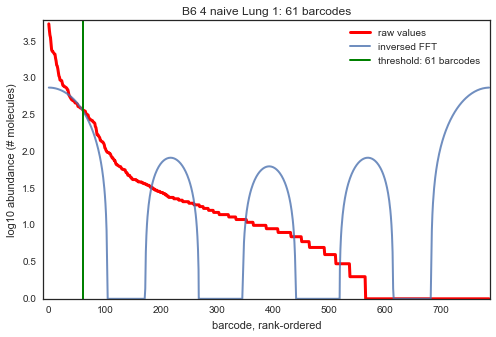

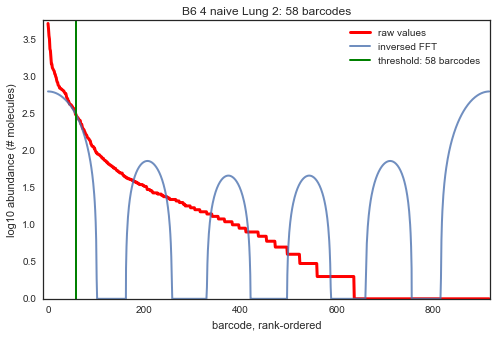

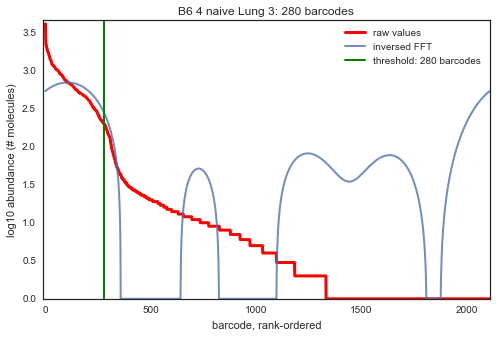

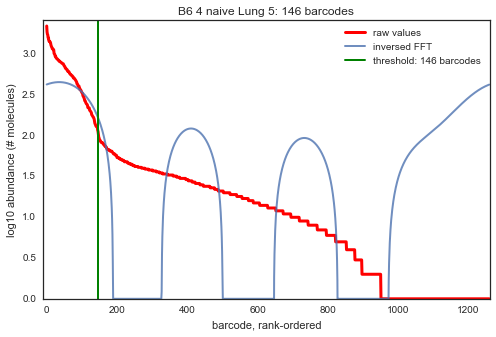

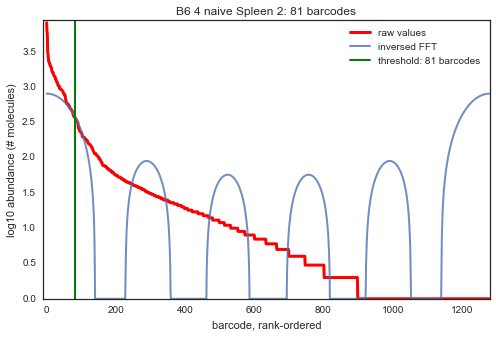

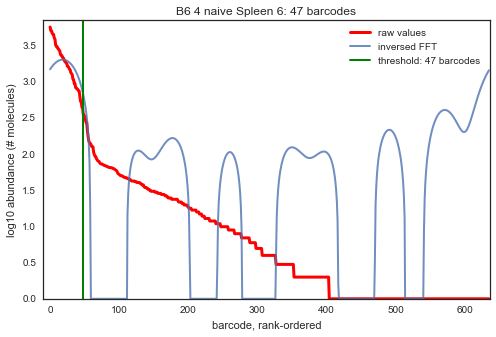

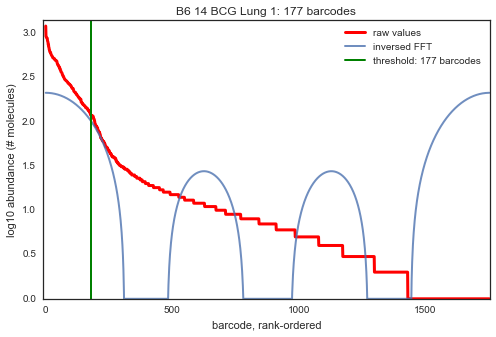

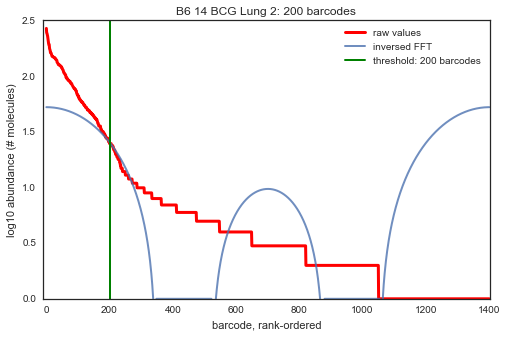

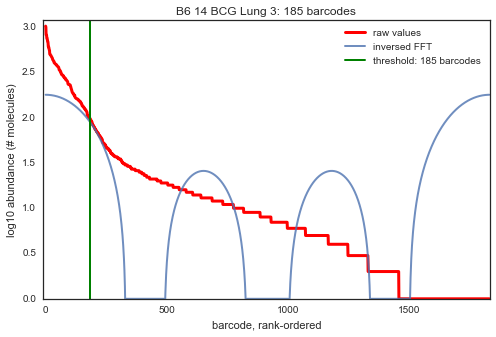

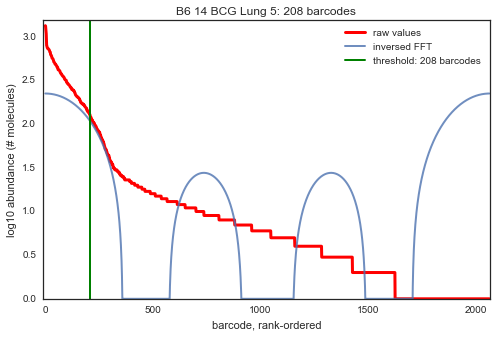

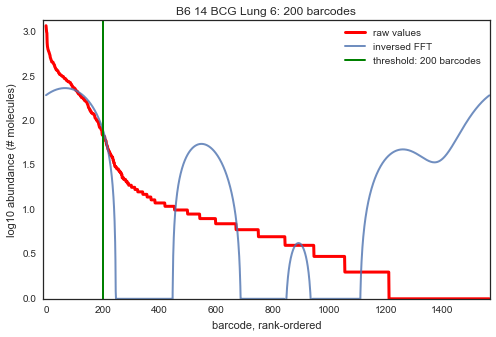

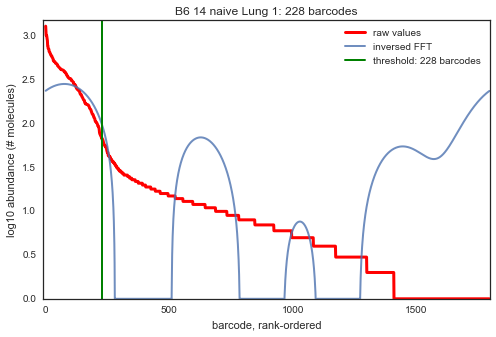

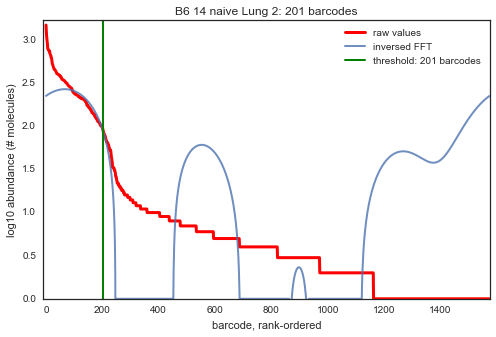

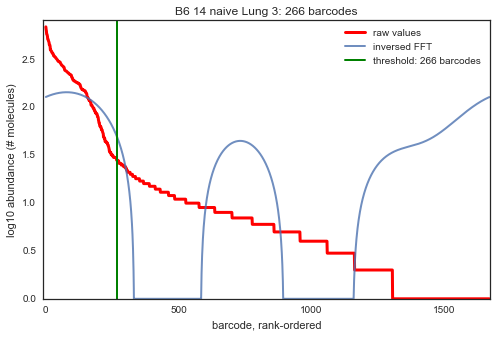

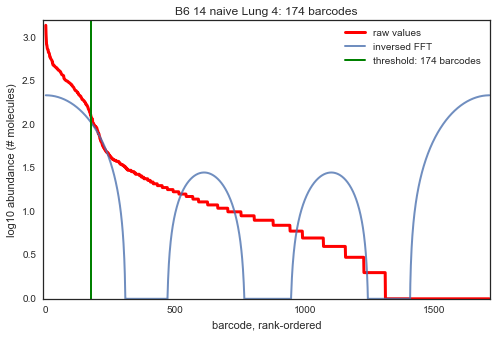

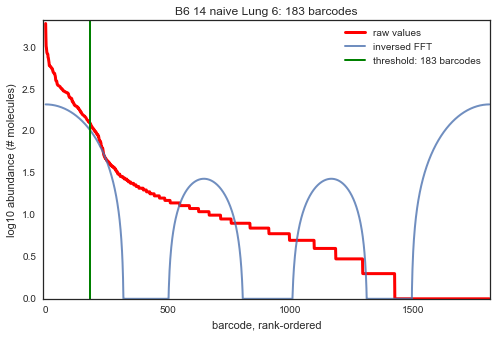

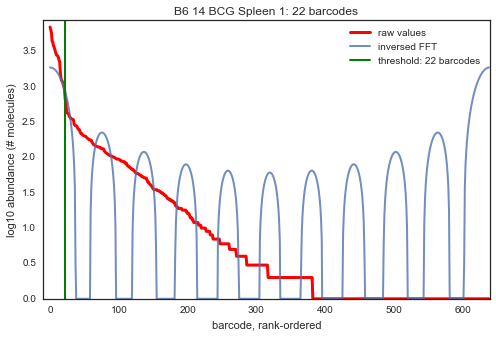

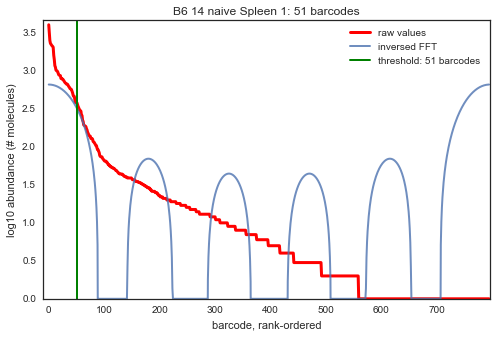

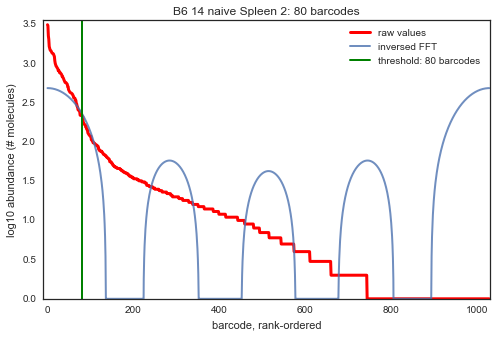

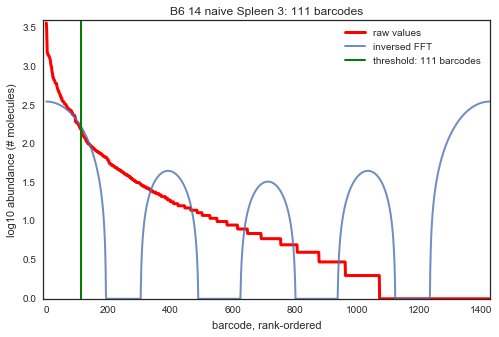

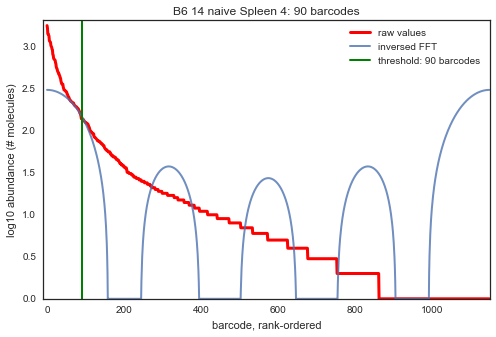

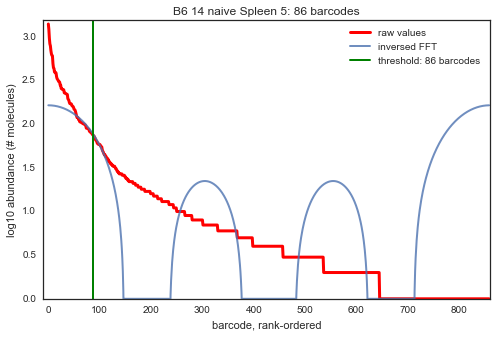

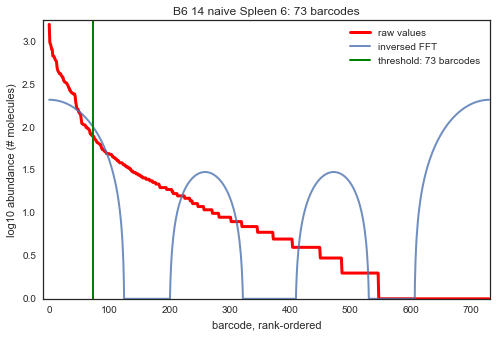

In [20]:
"""PLOT INDIVIDUAL SAMPLES"""
for sample_num, row in merged.iterrows():
    raw_y = row['raw_y']
    trans_y = row['trans_y']
    t = row.t
    row_info = [str(s) for s in row[groupby+['rep']]]
    f, ax = plot_transformed_sample(trans_y, raw_y, t,row_info)
    f.set_size_inches(8,5)
#     f.savefig("%s/figs-svg-indiv/%s.svg"%(OUTPUT_DIRECTORY,"-".join(row_info)))
#     f.savefig("%s/figs-png-indiv/%s.png"%(OUTPUT_DIRECTORY,"-".join(row_info)))

# PLOT BY GROUPS

### PLOT BY ALL (Mouse, Weeks, TB, Tissue)

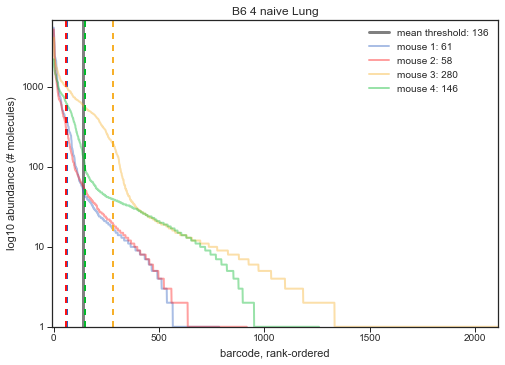

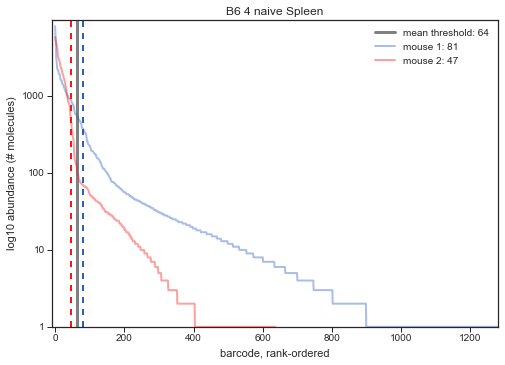

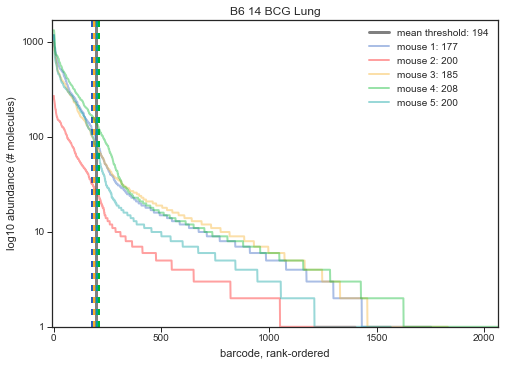

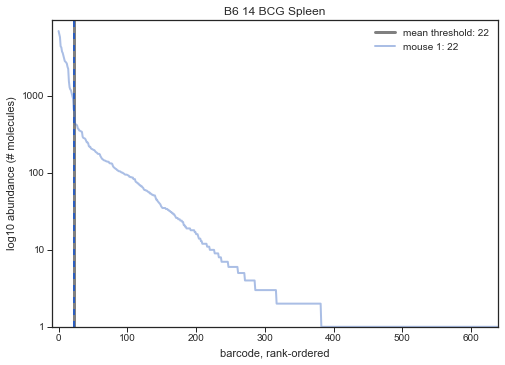

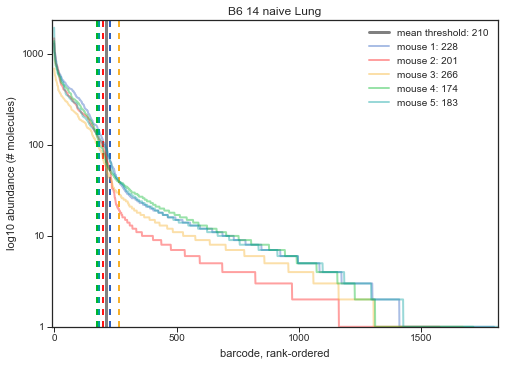

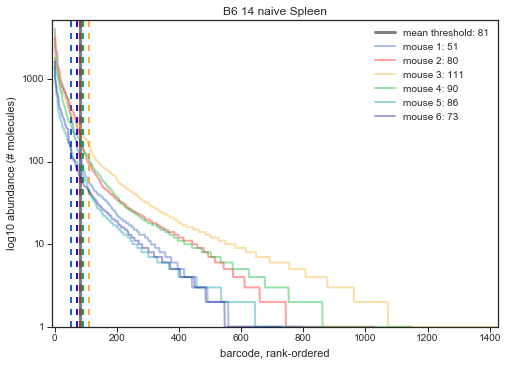

In [32]:
"""A)  PLOT PER GROUP W groupby_all"""
for _, row in pivoted.iterrows():
    trans_y, raw_y, t = row[['trans_y','raw_y','t']].values
    f1, ax1 = plt.subplots(1)
    title = " ".join([str(r_) for r_ in row[groupby]])
    y = raw_y

    yplot = [np.log10(yi) for yi in y]
    xplot = [range(len(yi)) for yi in y]
    
    alpha = 0.7
    span_vals = np.concatenate(raw_y)+np.concatenate(trans_y)
    tspan = np.log10([np.min(span_vals), np.max(span_vals)*1.1])
    tspan[np.isnan(tspan)] = 0
    avg_t = np.mean(t)
    
    ax1.plot([avg_t,avg_t],tspan, 
             lw=3, c=mean_color, alpha=1, label='mean threshold: %i'%avg_t)
    
    c = 0
    for tx, ty, ti in zip(xplot, yplot, t):
        color = colors[c%len(colors)]
        ax1.plot(tx, ty,lw=2, c=color, alpha=0.4, label="mouse %i: %i"%((c+1),ti))
        ax1.plot([ti,ti],tspan,lw=2, c=color, alpha=1, ls='--')
        c += 1
    xlabel = 'barcode, rank-ordered'
    ylabel = 'log10 abundance (# molecules)'

    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_ylim(top=tspan[1],bottom=0)
    ax1.set_xlim(left=-10,right=np.max([len(xi) for xi in xplot]))
    ax1.set_title(title)
    ax1.legend()
    old_yticklabels = [yt.get_text() for yt in ax1.get_yaxis().get_ticklabels()]
    new_yticklabels = [str(10**int(yt)) if len(yt)>0 else "" for yt in old_yticklabels]
    tspan[1]
    yticks = np.array([10**i for i in range(len(str(int(10**tspan[1]))))])
    ytickpos = np.log10(yticks)
    yticklabels = [str(yt) for yt in yticks]
    
    ax1.set_yticks(ytickpos)
    ax1.set_yticklabels(yticklabels)
    ax1.tick_params(length=5, axis='both', right='off',top='off')

#     break
    f1.savefig("%s/figs-svg-group/%s.svg"%(OUTPUT_DIRECTORY,"-".join(row_info)))
    f1.savefig("%s/figs-png-group/%s.png"%(OUTPUT_DIRECTORY,"-".join(row_info)))


### PLOT TISSUES TOGETHER

In [33]:
groupby_tissue = ['mouse_geno','week','tb_strain']

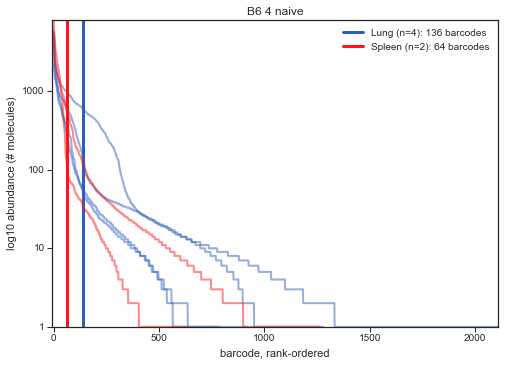

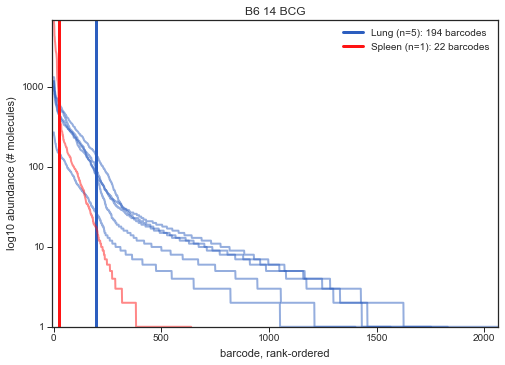

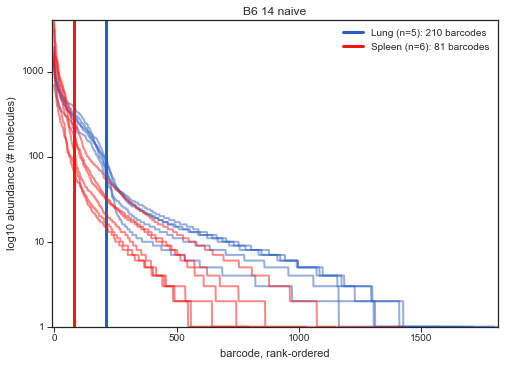

In [36]:
"""B)  PLOT PER GROUP comparing tissues"""
groups = pivoted.groupby(groupby_tissue)
y_param = 'raw_y'
for gname, group in groups:
    c = 0
    f1, ax1 = plt.subplots(1)
    title = " ".join([str(s) for s in gname])

    tspan = np.log10([1,
             np.max([ [np.max(r) for r in row] 
                for row in group[y_param].values])[0] 
            ])
    
    xlim_right = np.max([ np.max([len(r) for r in row]) 
                         for row in group[y_param].values] )
        
    c = 0
    for _, row in group.iterrows():
        tissue = row.tissue
        color = colors[c%len(colors)]
        y = row[y_param]
        yplot = [np.log10(yi) for yi in y]
        xplot = [range(len(yi)) for yi in y]
        
        avg_t = np.mean(row['t'])
        for tx, ty in zip(xplot, yplot):
            ax1.plot(tx, ty,lw=2, c=color, alpha=0.5)
            
        ax1.plot([avg_t,avg_t],tspan, 
             lw=3, c=color, alpha=1, label='%s (n=%i): %i barcodes'%(row.tissue,len(y),avg_t))
        c += 1



    ax1.set_xlabel('barcode, rank-ordered')
    ax1.set_ylabel('log10 abundance (# molecules)')
    ax1.set_ylim(tspan)
    ax1.set_xlim(-10,xlim_right)
    ax1.set_title(title)
    ax1.legend()
    
    yticks = np.array([10**i for i in range(len(str(int(10**tspan[1]))))])
    ytickpos = np.log10(yticks)
    yticklabels = [str(yt) for yt in yticks]
    
    ax1.set_yticks(ytickpos)
    ax1.set_yticklabels(yticklabels)
    ax1.tick_params(length=5, axis='both', right='off',top='off')
    f1.savefig("%s/figs-svg-group/%s.svg"%(OUTPUT_DIRECTORY,"-".join(row_info)))
    f1.savefig("%s/figs-png-group/%s.png"%(OUTPUT_DIRECTORY,"-".join(row_info)))



### APPENDIX 

In [ ]:
 """DFT code is from http://stackoverflow.com/questions/20618804/"""

""" [1] w = scipy.fftpack.rfft(y)

    Discrete Fourier transform of a real sequence
    rfft(x, n=None, axis=-1, overwrite_x=False); w= transformed y

    returns 
    [y(0),Re(y(1)),Im(y(1)),...,Re(y(n/2))]              if n is even
          [y(0),Re(y(1)),Im(y(1)),...,Re(y(n/2)),Im(y(n/2))]   if n is odd
     y(j) = sum[k=0..n-1] x[k] * exp(-sqrt(-1)*j*k*2*pi/n)
          j = 0..n-1
""" 
"""[2] f = scipy.fftpack.rfftfreq(N, x[1]-x[0])
        
    DFT sample frequencies (for usage with rfft, irfft)
    rfftfreq(n, d=1.0)
    n = window (usually size(w))
    d = sample space
    returns
    f = [0,1,1,2,2,...,n/2-1,n/2-1,n/2]/(d*n)   if n is even
      f = [0,1,1,2,2,...,n/2-1,n/2-1,n/2,n/2]/(d*n)   if n is odd

      where 
      The array of length `n`, containing the sample frequencies
    """



"""[2] y2 = scipy.fftpack.irfft(w2)

    irfft(x, n=None, axis=-1, overwrite_x=False)

    Return inverse discrete Fourier transform of real sequence x.

    The contents of `x` are interpreted as the output of the `rfft`
    function

    x : array_like
        Transformed data to invert.
    n : int, optional
        Length of the inverse Fourier transform.
        If n < x.shape[axis], x is truncated.
        If n > x.shape[axis], x is zero-padded.
        The default results in n = x.shape[axis].

        fn is similar to Inverse Fournier Transformation; 
        recovers function from FT: "statement is like if we know all
        frequency and phase information about a wave, then we may 
        reconstruct the original wave precisely". aka Fournier 
        integral theorem.
"""